# Pan cancer analysis of CPTAC proteomics
Here, we'll analyse proteomics between tumour and normal samples.

In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from adjustText import adjust_text
from sklearn.impute import KNNImputer
import cptac
import warnings

In [61]:
datasets = {"hnscc": cptac.Hnscc(),
            "ccrcc" : cptac.Ccrcc(),
            "luad" : cptac.Luad(),
            "lscc" : cptac.Lscc(),
            "ov" : cptac.Ov(),
            "en" : cptac.Ucec(),
            "coad" : cptac.Coad(),
            "pdac" : cptac.Pdac(),
            "brca" : cptac.Brca(),
            "ucec" : cptac.Ucec()}

# Get data
all_somatic_mutatation = pd.DataFrame()
for k, v in datasets.items():
    somatic_mutations = v.get_somatic_mutation('harmonized')
    all_somatic_mutatation = pd.concat([all_somatic_mutatation, somatic_mutations])
all_proteomics_data = pd.DataFrame()
for k, v in datasets.items():
    proteomics = v.get_proteomics("bcm")
    all_proteomics_data = pd.concat([all_proteomics_data, proteomics])

In [62]:
all_clinical = pd.DataFrame()

for k, v in datasets.items():
    clincal = v.get_clinical('mssm')
    all_clinical = pd.concat([all_clinical, clincal])

In [63]:
pan_proteomics = all_proteomics_data.copy()
pan_proteomics.columns = ['_'.join(map(str, col)) for col in pan_proteomics.columns]

Inspect degree of missingness. Should we impute?

<Axes: ylabel='Patient_ID'>

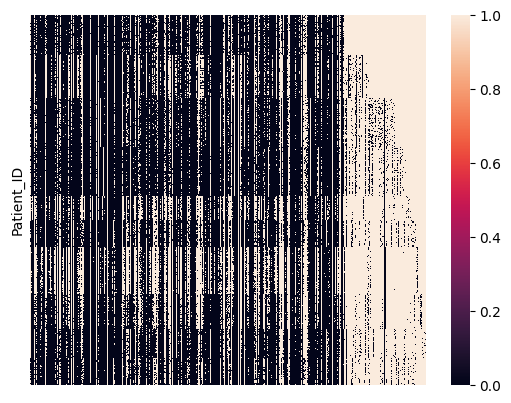

In [64]:
sns.heatmap(pan_proteomics.isna(), yticklabels=False, xticklabels=False)

Lets drop columns missing > 50% of data. Then, we will perform two differential abundance analyses:
- *Analysis 1* will be conducted by simply dropping missing values.
- *Analysis 2* will apply imputation. 

<Axes: ylabel='Patient_ID'>

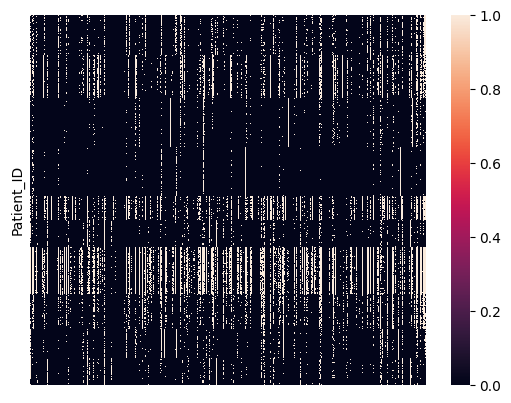

In [65]:
pan_proteomics = pan_proteomics.loc[:,pan_proteomics.isna().sum() / pan_proteomics.shape[0] < 0.5]
sns.heatmap(pan_proteomics.isna(), yticklabels=False, xticklabels=False)

Lets write some functions for testing and reviewing results.

In [66]:
### Function for diff testing ##
# Lets create a class to catch / store warnings that may occr
class WarningFlag:
    def __init__(self):
        self.detected = False
        self.warning_type = None
        self.warning_message = None
        
def test_differences(df, comp_var = "Sample_type"):
    # for catching any warnings
    flag = WarningFlag()
    # Basic calculations
    abundance_t = df[df[comp_var] == 1]["Abundance"]
    abundance_n = df[df[comp_var] == 0]["Abundance"]
    n_t = len(abundance_t)
    n_n = len(abundance_n)
    delta = abundance_t.mean() - abundance_n.mean()
    ### Statistical testing with error handling
    # T test
    try:
        with warnings.catch_warnings(record=True) as caught_warnings_ttest:
            warnings.simplefilter("always")
            t_stat, tp_val = ttest_ind(abundance_t, abundance_n, nan_policy="omit")
            if caught_warnings_ttest:
                flag.detected = True
                flag.warning_type = caught_warnings_ttest[0].category.__name__
                flag.warning_message = str(caught_warnings_ttest[0].message)
            warning_messages_ttest = [str(warn.message) for warn in caught_warnings_ttest]
    except Exception as e:
        t_stat = np.nan
        tp_val = np.nan
        warning_messages_ttest = str(e)

    # Mann-Whitney U test
    try:
        with warnings.catch_warnings(record=True) as caught_warnings_mwu:
            warnings.simplefilter("always")
            mwu_stat, mwup_val = mannwhitneyu(abundance_t, abundance_n, alternative="two-sided")
            if caught_warnings_mwu:
                flag.detected = True
                flag.warning_type = caught_warnings_mwu[0].category.__name__
                flag.warning_message = str(caught_warnings_mwu[0].message)
            warning_messages_mwu = [str(warn.message) for warn in caught_warnings_mwu]
    except Exception as e:
        mwu_stat = np.nan
        mwup_val = np.nan
        warning_messages_mwu = str(e)

    return pd.Series({
        "n_normal": n_n,
        "n_tumour": n_t,
        "Delta": delta,
        "T_stat": t_stat,
        "T_P_val": tp_val,
        "MWU_stat": mwu_stat,
        "MWU_P_val": mwup_val,
        "warning_ttest": warning_messages_ttest,
        "warning_MWU": warning_messages_mwu,
        "warnings_detected": flag.detected,
        "warning_type": flag.warning_type,
        "warning_message": flag.warning_message
    })

In [67]:
def volcano(df, 
            xcol = "Delta",
            ycol = "p_adj",
            label_x_threshold = None,
            label_y_threshold = None):
    # Create plot
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(True, linestyle='-', linewidth=0.5, color="lightgrey")
    ax.scatter(x = df[xcol], y = -np.log10(df[ycol]), color="#000000", alpha=0.7)
    ax.set_ylabel("-log10(p value)") 
    threshold = -np.log10(0.05)
    ax.axhline(threshold, color="red", linestyle="--", label="Threshold: -log10(0.05)")
    ax.spines["top"].set_linewidth(1)
    ax.spines["right"].set_linewidth(1)
    ax.spines["bottom"].set_linewidth(1)
    ax.spines["left"].set_linewidth(1)
    # Add labels if you want
    if label_x_threshold is not None and label_y_threshold is not None:
        texts = []
        for index, row in df.iterrows():
            y_val = -np.log10(row[ycol])
            if (row[xcol] > label_x_threshold or row[xcol] < -label_x_threshold) and y_val > -np.log10(label_y_threshold):
                text = ax.text(row[xcol], -np.log10(row[ycol]), f"({row['Protein']})", 
                               fontsize=9, ha='center', va='center', color='black')
                texts.append(text)
        adjust_text(texts, arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
        ax.set_xlim(ax.get_xlim()[0] - 0.5, ax.get_xlim()[1] + 0.5)
        ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + 0.5)

## Analysis 1

In [68]:
pan_cancer_analysis1 = (pan_proteomics
                        .reset_index()
                        .melt(id_vars="Patient_ID", 
                              var_name = "Protein",
                              value_name="Abundance")
)
pan_cancer_analysis1 = pan_cancer_analysis1.assign(Sample_type = np.where(pan_cancer_analysis1["Patient_ID"].str.contains(r"\.N$", regex=True),
                                                                          0, # 0 for normal
                                                                          1)) # 1 for tumour
pan_cancer_analysis1 = pan_cancer_analysis1[~pan_cancer_analysis1["Abundance"].isna()]

In [69]:
analysis1_diff_tests = pan_cancer_analysis1.groupby("Protein").apply(test_differences)

C:\Users\hfy163\AppData\Local\Temp\ipykernel_26352\6887681.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analysis1_diff_tests = pan_cancer_analysis1.groupby("Protein").apply(test_differences)


In [70]:
# Get rid of tests which had less than 10 individuals in either group
analysis1_diff_tests2 = analysis1_diff_tests[(analysis1_diff_tests["n_normal"] > 9) & (analysis1_diff_tests["n_tumour"] > 9)]

In [71]:
_, fdr_p_values, _, _ = multipletests(analysis1_diff_tests2["MWU_P_val"], method="fdr_bh")
analysis1_diff_tests2["MWU_P_adj"] = fdr_p_values

In [72]:
analysis1_diff_tests2.reset_index(inplace=True)

Quite a few significant hits, perphaps a stronger FDR control method required.

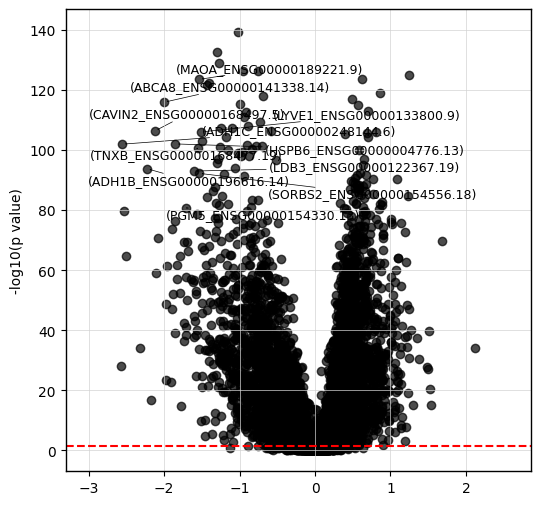

In [74]:
volcano(df = analysis1_diff_tests2,
        xcol="Delta",
        ycol = "MWU_P_adj",
        label_x_threshold= 1.5,
        label_y_threshold=1e-80)

## Analysis 2

In [78]:
pan_proteomics_imputed = pan_proteomics
imputer = KNNImputer(n_neighbors=3) # just a starting point
imputer.fit_transform(pan_proteomics_imputed)
pan_proteomics_imputed = imputer.fit_transform(pan_proteomics_imputed)
pan_proteomics_imputed = pd.DataFrame(pan_proteomics_imputed, columns=pan_proteomics.columns)

<Axes: >

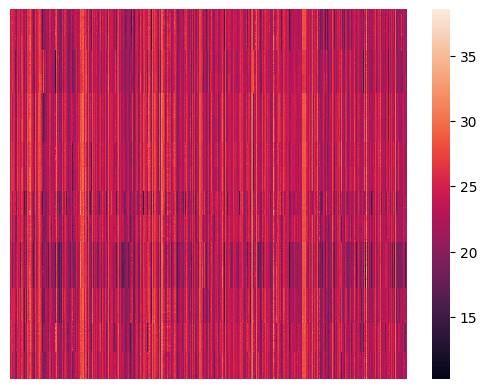

In [79]:
sns.heatmap(pan_proteomics_imputed, yticklabels=False, xticklabels=False)

In [ ]:
pan_proteomics_imputed.index = pan_proteomics.index

In [85]:
pan_cancer_analysis2 = (pan_proteomics_imputed
                        .reset_index()
                        .melt(id_vars="Patient_ID", 
                              var_name = "Protein",
                              value_name="Abundance")
)
pan_cancer_analysis2 = pan_cancer_analysis2.assign(Sample_type = np.where(pan_cancer_analysis2["Patient_ID"].str.contains(r"\.N$", regex=True),
                                                                          0, # 0 for normal
                                                                          1)) # 1 for tumour

In [86]:
analysis2_diff_tests = pan_cancer_analysis2.groupby("Protein").apply(test_differences)

C:\Users\hfy163\AppData\Local\Temp\ipykernel_26352\2600189221.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  analysis2_diff_tests = pan_cancer_analysis2.groupby("Protein").apply(test_differences)


In [87]:
analysis2_diff_tests = analysis2_diff_tests[(analysis2_diff_tests["n_normal"] > 9) & (analysis2_diff_tests["n_tumour"] > 9)]
_, fdr_p_values, _, _ = multipletests(analysis2_diff_tests["MWU_P_val"], method="fdr_bh")
analysis2_diff_tests["MWU_P_adj"] = fdr_p_values

In [ ]:
analysis2_diff_tests.reset_index(inplace=True)

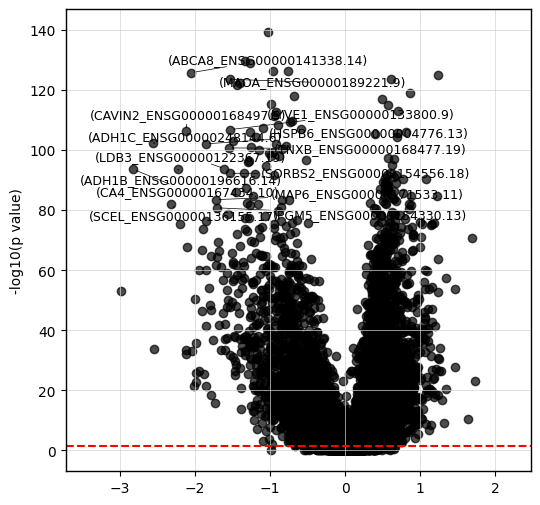

In [ ]:
volcano(df = analysis2_diff_tests,
        xcol="Delta",
        ycol = "MWU_P_adj",
        label_x_threshold= 1.5,
        label_y_threshold=1e-80)